https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

In [1]:
import pandas as pd

In [46]:
df = pd.read_csv('../Misc/Consumer_Complaints.csv')

In [47]:
df = df[:25000]
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/12/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,03/17/2014,Closed with explanation,Yes,No,759217
1,01/19/2017,Student loan,Federal student loan servicing,Dealing with my lender or servicer,Received bad information about my loan,When my loan was switched over to Navient i wa...,NaN,"Navient Solutions, LLC.",LA,NaN,NaN,Consent provided,Web,01/19/2017,Closed with explanation,Yes,No,2296496
2,04/06/2018,Credit card or prepaid card,General-purpose credit card or charge card,"Other features, terms, or problems",Other problem,I tried to sign up for a spending monitoring p...,NaN,CAPITAL ONE FINANCIAL CORPORATION,VA,NaN,Older American,Consent provided,Web,04/06/2018,Closed with explanation,Yes,NaN,2866101
3,06/08/2014,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,06/10/2014,Closed with explanation,Yes,Yes,885638
4,09/13/2014,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,09/13/2014,Closed with explanation,Yes,Yes,1027760


In [48]:
df = df[pd.notnull(df['Consumer complaint narrative'])]

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4692 entries, 1 to 24997
Data columns (total 18 columns):
Date received                   4692 non-null object
Product                         4692 non-null object
Sub-product                     4238 non-null object
Issue                           4692 non-null object
Sub-issue                       3581 non-null object
Consumer complaint narrative    4692 non-null object
Company public response         2262 non-null object
Company                         4692 non-null object
State                           4668 non-null object
ZIP code                        3613 non-null object
Tags                            830 non-null object
Consumer consent provided?      4692 non-null object
Submitted via                   4692 non-null object
Date sent to company            4692 non-null object
Company response to consumer    4691 non-null object
Timely response?                4692 non-null object
Consumer disputed?              1383 non-null

In [50]:
df = df[['Product', 'Consumer complaint narrative']]

In [51]:
df.columns

Index(['Product', 'Consumer complaint narrative'], dtype='object')

In [52]:
df.columns = ['Product', 'Consumer_complaint_narrative']

In [53]:
df['category_id'] = df['Product'].factorize()[0]

In [54]:
from io import StringIO

category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

In [55]:
df.head()

,Product,Consumer_complaint_narrative,category_id
1,Student loan,When my loan was switched over to Navient i wa...,0
2,Credit card or prepaid card,I tried to sign up for a spending monitoring p...,1
7,Mortgage,"My mortgage is with BB & T Bank, recently I ha...",2
13,Mortgage,The entire lending experience with Citizens Ba...,2
14,Credit reporting,My credit score has gone down XXXX points in t...,3


Conventional algorithms are often biased towards the majority class, not taking the data distribution into consideration. In the worst case, minority classes are treated as outliers and ignored. For some cases, such as fraud detection or cancer prediction, we would need to carefully configure our model or artificially balance the dataset, for example by undersampling or oversampling each class.

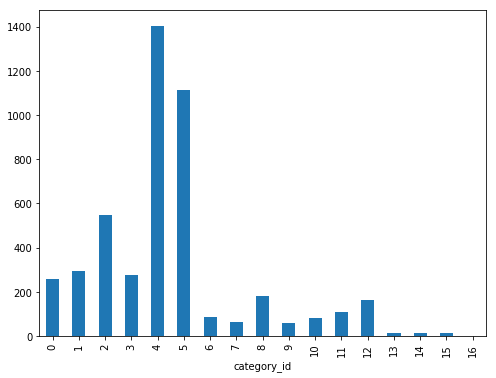

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,6))
df.groupby('category_id')['Consumer_complaint_narrative'].count().plot.bar(ylim=0)

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1,2), stop_words='english')
features = tfidf.fit_transform(df.Consumer_complaint_narrative).toarray()
labels = df.category_id
features.shape

(4692, 13720)

We can use sklearn.feature_selection.chi2 to find the terms that are the most correlated with each of the products:

### *Imp

In [62]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(" ")) == 1]
    bigrams = [v for v in feature_names if len(v.split(" ")) == 2]
    print("# '{}':".format(Product))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))    

# 'Bank account or service':
  . Most correlated unigrams:
       . citigold
       . overdrawn
  . Most correlated bigrams:
       . checking account
       . overdraft fees
# 'Checking or savings account':
  . Most correlated unigrams:
       . deposit
       . overdraft
  . Most correlated bigrams:
       . business checking
       . checking account
# 'Consumer Loan':
  . Most correlated unigrams:
       . nissan
       . vehicle
  . Most correlated bigrams:
       . automatic payment
       . vehicle loan
# 'Credit card':
  . Most correlated unigrams:
       . citi
       . card
  . Most correlated bigrams:
       . credit card
       . american express
# 'Credit card or prepaid card':
  . Most correlated unigrams:
       . rewards
       . card
  . Most correlated bigrams:
       . card xx
       . credit card
# 'Credit reporting':
  . Most correlated unigrams:
       . experian
       . equifax
  . Most correlated bigrams:
       . reporting company
       . removed file
# 'Cred

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state=0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [69]:
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

['Debt collection']


In [70]:
print(clf.predict(count_vect.transform(["I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"])))

['Credit reporting, credit repair services, or other personal consumer reports']


In [71]:
df[df['Consumer_complaint_narrative'] == "This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."]

,Product,Consumer_complaint_narrative,category_id
6555,Debt collection,This company refuses to provide me verificatio...,5


In [72]:
df[df['Consumer_complaint_narrative'] == "I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"]

,Product,Consumer_complaint_narrative,category_id
6915,Credit reporting,I am disputing the inaccurate information the ...,3


### *imp*

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\Users\Sony\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Sony\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Sony\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Sony\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimu

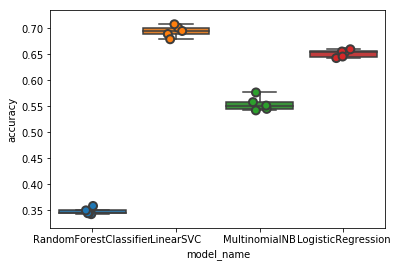

In [80]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [82]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.694580
LogisticRegression        0.651744
MultinomialNB             0.554762
RandomForestClassifier    0.347847
Name: accuracy, dtype: float64

In [83]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

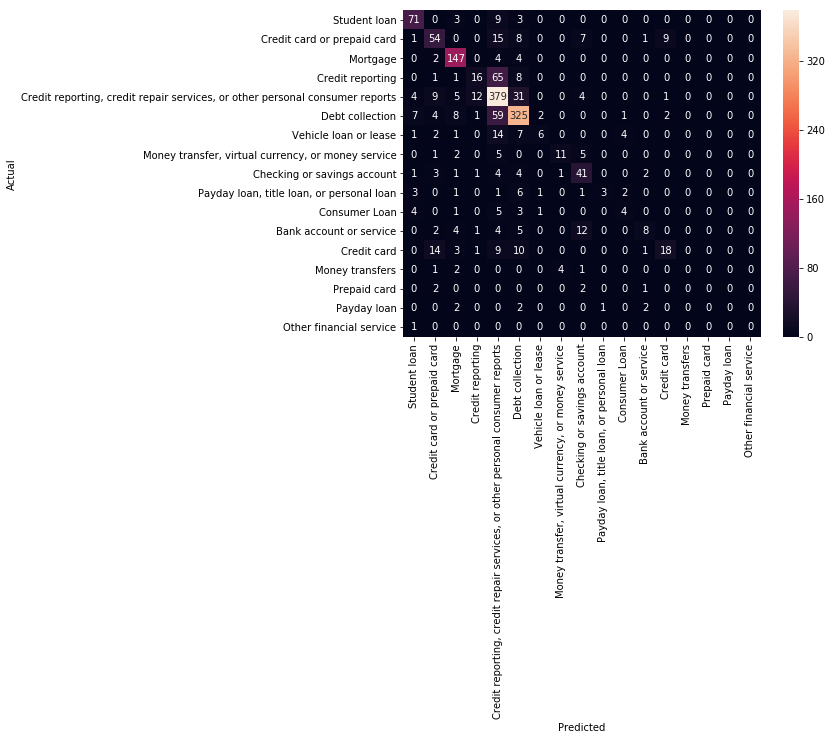

In [92]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [94]:
from IPython.display import display

for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] > 6 :
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_complaint_narrative']])
            print('')

'Debt collection' predicted as 'Student loan' : 7 examples.


,Product,Consumer_complaint_narrative
14002,Debt collection,"The collection agency XXXX XXXX XXXX, is haras..."
11447,Debt collection,They sent me a letter threatening to take lega...
14774,Debt collection,I have three ( 3 ) PLUS loans with a standard ...
14259,Debt collection,I have student loans for which I will qualify ...
4399,Debt collection,"The XXXX XXXX ( Now, XXXX XXXX ) originated in..."
7207,Debt collection,I am paying Navient every month for mt student...
8850,Debt collection,"I attended a college in XXXX, XXXX in XXXX, Fl..."



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit card or prepaid card' : 9 examples.


,Product,Consumer_complaint_narrative
17656,"Credit reporting, credit repair services, or o...",I am trying to link my Capital One checking ac...
16263,"Credit reporting, credit repair services, or o...",Capital One is listing a card on my credit tha...
22936,"Credit reporting, credit repair services, or o...",Someone my ex wife is using my social security...
18533,"Credit reporting, credit repair services, or o...",Portfolio Recovery Associates I recently paid ...
21525,"Credit reporting, credit repair services, or o...",By the amount of {$3400.00} dollars my credit ...
19724,"Credit reporting, credit repair services, or o...",Applied for XXXX XXXX card on XX/XX/XXXX ( XXX...
3410,"Credit reporting, credit repair services, or o...",filled out an application for a XXXX XXXX XXXX...
5265,"Credit reporting, credit repair services, or o...",I had an automatic payment of {$50.00} schedul...
15381,"Credit reporting, credit repair services, or o...",Bank of America sent me balance transfer check...



'Credit card' predicted as 'Credit card or prepaid card' : 14 examples.


,Product,Consumer_complaint_narrative
3016,Credit card,I do n't know how but PayPal said I opened a c...
9271,Credit card,My credit card is paid by my Dad from his acco...
9227,Credit card,I have been a loyal customer of Capital One fo...
2909,Credit card,XXXX Please take a look at this link above. I ...
21009,Credit card,"On XX/XX/XXXX, I purchased a Samsung Smart TV ..."
6782,Credit card,"Without provocation, I received notice that my..."
9286,Credit card,Let me start by saying that I have a credit sc...
1392,Credit card,I went to buy pants at the store and the clerk...
1239,Credit card,Capital One credit card complaint. Received ca...
850,Credit card,1. In XX/XX/2015 I ordered a pair of hunting b...



'Debt collection' predicted as 'Mortgage' : 8 examples.


,Product,Consumer_complaint_narrative
24161,Debt collection,I was part of a class action lawsuit against X...
5709,Debt collection,XX/XX/XXXX Bank of America transferred my titl...
7852,Debt collection,"I requested for "" Detail of the sale dollar tr..."
14678,Debt collection,I had this problem with PHH Mortgage some year...
22208,Debt collection,"The collector calls every other day, and somet..."
2100,Debt collection,In XXXX we sold our home in XXXX Ca. The mortg...
21405,Debt collection,I was getting Medicaid through the government ...
24932,Debt collection,XXXX XXXX XXXX XXXX ( XXXX ) is in violation o...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit reporting' : 12 examples.


,Product,Consumer_complaint_narrative
2669,"Credit reporting, credit repair services, or o...",I am filing this complaint because Equifax has...
6902,"Credit reporting, credit repair services, or o...",I was interested in doing refinance on my car ...
19232,"Credit reporting, credit repair services, or o...",I am having trouble with a Experian website th...
19538,"Credit reporting, credit repair services, or o...",I called about unknown hard inquiries on my cr...
1433,"Credit reporting, credit repair services, or o...","I disputed, with all credit reporting agencies..."
17357,"Credit reporting, credit repair services, or o...",Equifax continues to commit Fraud. I have alre...
4036,"Credit reporting, credit repair services, or o...",Incorrect information about date of birth and ...
16062,"Credit reporting, credit repair services, or o...",experian placed a fraud alert without my autho...
3657,"Credit reporting, credit repair services, or o...",Experian continues to report 4 collection acco...
6366,"Credit reporting, credit repair services, or o...",This is a follow up to my previous complaint ....



'Student loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 9 examples.


,Product,Consumer_complaint_narrative
21925,Student loan,I was told loan was discharged in BK in XXXX. ...
15487,Student loan,In early XXXX I signed an agreement with ...
9611,Student loan,I received my XXXX from XXXX XXXX in XX/XX/201...
21836,Student loan,NAVIENT has been incorrectly reporting the ori...
23901,Student loan,They are many account open under my name and t...
18895,Student loan,"I graduated from XXXX University back in XXXX,..."
6976,Student loan,They have reported false information about my ...
9783,Student loan,My private loan accounts were initially owned ...
18448,Student loan,Im having problems with 2 separate loan compan...



'Credit card or prepaid card' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 15 examples.


,Product,Consumer_complaint_narrative
19614,Credit card or prepaid card,XX/XX/18 ordered {$140.00} from XXXX XXXX and...
15414,Credit card or prepaid card,"Hello, An American Express credit card is show..."
16355,Credit card or prepaid card,Ive sent letters to this company about my fami...
6011,Credit card or prepaid card,"In XX/XX/XXXX, I cancelled the XXXX card that ..."
23213,Credit card or prepaid card,The company I work for changed our email addre...
6000,Credit card or prepaid card,I never opened the card and reported it a lot ...
5659,Credit card or prepaid card,"I HAVE TWO OPEN WITH XXXX XXXX XXXX, XXXX NO.X..."
5631,Credit card or prepaid card,"I was advised by XXXX XXXX XXXX, XXXX XXXX XXX..."
11702,Credit card or prepaid card,"I asked capital one, via telephone to have my ..."
22570,Credit card or prepaid card,I sent a Goodwill letter to Capital One explai...



'Credit reporting' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 65 examples.


,Product,Consumer_complaint_narrative
733,Credit reporting,Attempted to temporarily lift a freeze at Tran...
15956,Credit reporting,"XXXX, Equifax, and XXXX placed fraud alerts on..."
1521,Credit reporting,I am a XXXX XXXX XXXX XXXX and Veteran. I am a...
10093,Credit reporting,DOB : XX/XX/XXXXSSN : XXXXFile # XXXXDear Sir ...
7404,Credit reporting,I have disputed with the credit burea regardin...
6484,Credit reporting,. I have tried to have the following item inve...
7678,Credit reporting,I had received several letters from XXXX XXXX ...
23960,Credit reporting,The bureau is reporting false information on m...
7532,Credit reporting,I disputed information on my credit report tha...
11266,Credit reporting,XXXX has put a negative account on my credit f...



'Debt collection' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 59 examples.


,Product,Consumer_complaint_narrative
22204,Debt collection,I would like to ask for your assistance in thi...
19698,Debt collection,"At the beginning of XX/XX/XXXX I had a "" jump ..."
21559,Debt collection,For the past 4 years I have been dealing with ...
10318,Debt collection,In XX/XX/XXXX I checked my credit report and c...
2592,Debt collection,Dates of service keep changing but insurance h...
19912,Debt collection,On XXXX XXXX JH Debt Portfolio Debt Equities f...
13374,Debt collection,In the year of XX/XX/XXXX my identification wa...
7045,Debt collection,This collection account was in error by XXXX X...
562,Debt collection,I used to use XXXX 's XXXX card. I stopped the...
17360,Debt collection,I would like to file a formal complaint agains...



'Vehicle loan or lease' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 14 examples.


,Product,Consumer_complaint_narrative
22937,Vehicle loan or lease,I leased a car from BMW. It was my third lease...
10090,Vehicle loan or lease,Capital One account # XXXX never sent a bill o...
12788,Vehicle loan or lease,I was sent a letter of notice stating that I n...
7056,Vehicle loan or lease,I was in a major accident and my vehicle was d...
4362,Vehicle loan or lease,We feel that we were given misleading informat...
11381,Vehicle loan or lease,THIS IS MY LAST REQUEST FOR RESOLUTION. I WILL...
19519,Vehicle loan or lease,U.S. Bank Branch XXXX XXXX XXXX XXXX 0.7 mi XX...
8022,Vehicle loan or lease,XXXX XXXX made several calls and sent two remi...
14842,Vehicle loan or lease,I completed my payments on my auto loan on XX/...
1535,Vehicle loan or lease,XX/XX/XXXX XX/XX/XXXX XX/XX/XXXX ( west lake f...



'Credit card' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 9 examples.


,Product,Consumer_complaint_narrative
4545,Credit card,Was unsatisfied with the way Discover was hand...
450,Credit card,Inaccurate and misleading response to a cfpb c...
2269,Credit card,I am opted out from receiving promotional offe...
18927,Credit card,On XXXX XXXX we entered an agreement with XXXX...
9431,Credit card,I had XXXX credit card accounts with HSBC. The...
3375,Credit card,"On XXXX XXXX, XXXX a representative from Chase..."
6536,Credit card,I am XXXX and own a home in SC. My XXXX compan...
2611,Credit card,CFPB case # XXXX XXXX weeks and no response. S...
13432,Credit card,I have received a copy of my credit report and...



'Credit card or prepaid card' predicted as 'Debt collection' : 8 examples.


,Product,Consumer_complaint_narrative
11991,Credit card or prepaid card,I issued a statement to the CFPB regarding Dis...
8072,Credit card or prepaid card,Discover Card has harassed me about a credit c...
352,Credit card or prepaid card,On Friday XX/XX/2018 I noticed a {$160.00} cha...
15393,Credit card or prepaid card,Summary : XX/XX/XXXX - Granite was to be purch...
14826,Credit card or prepaid card,"On XXXX, we ordered a phone using our rewards ..."
16781,Credit card or prepaid card,On XX/XX/XXXX I authorized a check with Bluebi...
8869,Credit card or prepaid card,XXXX XX/XX/XXXX To : Dispute Resolution Servic...
77,Credit card or prepaid card,Alleged company use scare tactics to threaten ...



'Credit reporting' predicted as 'Debt collection' : 8 examples.


,Product,Consumer_complaint_narrative
2526,Credit reporting,XXXX XXXX has indicated it has finished its in...
14145,Credit reporting,"I had cell phone service through XXXX, I had t..."
415,Credit reporting,XXXX and Transunion has violated the FCRA Sect...
16641,Credit reporting,I am a XXXX who was receiving XXXX from VA. In...
16746,Credit reporting,I have been reviewing my credit files and noti...
19968,Credit reporting,I have on several occasions disputed an accoun...
11894,Credit reporting,A debt shows on my report as a recent debt of ...
14322,Credit reporting,I open a gym account and a few weeks later got...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Debt collection' : 31 examples.


,Product,Consumer_complaint_narrative
5216,"Credit reporting, credit repair services, or o...",Made an investigation with all major credit re...
20164,"Credit reporting, credit repair services, or o...",The original owner was XXXX XXXX sold to XXXX...
4299,"Credit reporting, credit repair services, or o...",I previously filed a complaint against Mountai...
1972,"Credit reporting, credit repair services, or o...",In XX/XX/2018 I sent a dispute to TransUnion r...
14082,"Credit reporting, credit repair services, or o...",I have several discrepancies on my credit repo...
24618,"Credit reporting, credit repair services, or o...",The company reported a collection account for ...
15046,"Credit reporting, credit repair services, or o...",The company has had multiple request for proof...
15020,"Credit reporting, credit repair services, or o...",On XX/XX/2018 a debt validation pursuant to la...
3883,"Credit reporting, credit repair services, or o...",I have a serious problem with anything that ha...
2025,"Credit reporting, credit repair services, or o...",i was hacked.



'Vehicle loan or lease' predicted as 'Debt collection' : 7 examples.


,Product,Consumer_complaint_narrative
19221,Vehicle loan or lease,I have had lot of medical issue s and had my g...
3577,Vehicle loan or lease,"Not Liable, Car Was A Lemon, Repossessed. And ..."
17767,Vehicle loan or lease,XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX # XXXX...
19723,Vehicle loan or lease,"I took out a loan for a vehicle in XX/XX/XXXX,..."
16060,Vehicle loan or lease,I have a loan with volkwagen credit. They have...
11660,Vehicle loan or lease,I AM XXXX XXXX XXXX AS EX HUSBAND LAST NAME IS...
1075,Vehicle loan or lease,I have an unverified account from BRIDGECREST ...



'Credit card' predicted as 'Debt collection' : 10 examples.


,Product,Consumer_complaint_narrative
24555,Credit card,"As noted in the letter CFPB Case No. : XXXX, A..."
1011,Credit card,XXXX of 2015 I received a statement from Macy ...
23912,Credit card,I have had Barclaycard since XXXX. I enjoy usi...
15928,Credit card,My husband lost his job and I was unable to pa...
3118,Credit card,"back in XX/XX/XXXX, I spoke with a representat..."
1037,Credit card,In XXXX I had a hardship. I noticed that no ma...
18552,Credit card,I noticed XXXX fradulent charges on my account...
15129,Credit card,I have XXXX citibank credit cards. My simplici...
15468,Credit card,"In XX/XX/XXXX, my husband passed away after a ..."
15989,Credit card,Kohls account from XXXX I was denied at the st...



'Credit card or prepaid card' predicted as 'Checking or savings account' : 7 examples.


,Product,Consumer_complaint_narrative
659,Credit card or prepaid card,My card was used at a grocery store for XXXX d...
17242,Credit card or prepaid card,I found a complaint stating that the merchandi...
18796,Credit card or prepaid card,This is regarding my PayPal debit card account...
2,Credit card or prepaid card,I tried to sign up for a spending monitoring p...
21438,Credit card or prepaid card,"In XX/XX/XXXX, I filed a complaint with the CF..."
2960,Credit card or prepaid card,Chase Freedom misrepresented crucial acts of t...
17683,Credit card or prepaid card,My father passed away. I notified XXXX XXXX of...



'Bank account or service' predicted as 'Checking or savings account' : 12 examples.


,Product,Consumer_complaint_narrative
15443,Bank account or service,"To whom this may concern, I opened a Citibank ..."
8175,Bank account or service,I wired my Aunt {$1000.00}. The wire was sent ...
20603,Bank account or service,"I am filing this on behalf of my mother, who i..."
10856,Bank account or service,PNC Bank charged me XXXX in overdraft fees for...
11563,Bank account or service,"On XXXX XXXX, 2015 I called to Chase bank tell..."
12836,Bank account or service,On or about XXXX/XXXX/15 PNC Bank charged our ...
4782,Bank account or service,Dear CFPB : The ONLY Bank of America office an...
14213,Bank account or service,This company said they will close my account f...
17707,Bank account or service,"I am so disappointed in Bank of America, and t..."
12969,Bank account or service,PNC Bank is continually causing issues with my...



'Credit card or prepaid card' predicted as 'Credit card' : 9 examples.


,Product,Consumer_complaint_narrative
15062,Credit card or prepaid card,The Priority Pass benefit that Chase offers on...
16784,Credit card or prepaid card,I paid on XX/XX/XXXX my American Express credi...
3173,Credit card or prepaid card,I paid XXXX XXXX a deposit via opening a Care ...
901,Credit card or prepaid card,Discover Card has been charging me a fee label...
13438,Credit card or prepaid card,I went into an HSBC bank to change my name aft...
13852,Credit card or prepaid card,"I have been a 20 plus year customer, in good s..."
14386,Credit card or prepaid card,American Express is a disgraceful company. I a...
19584,Credit card or prepaid card,Somehow my credit card number was stolen and f...
7501,Credit card or prepaid card,On X/XX/2017 I received an email from Chas...


In [96]:
model.fit(features, labels)

N = 2
for Product, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(Product))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Bank account or service':
  . Top unigrams:
       . overdrawn
       . promotion
  . Top bigrams:
       . card number
       . credit union
# 'Checking or savings account':
  . Top unigrams:
       . overdraft
       . deposit
  . Top bigrams:
       . debit card
       . 00 bonus
# 'Consumer Loan':
  . Top unigrams:
       . vehicle
       . auto
  . Top bigrams:
       . automatic payment
       . keeps calling
# 'Credit card':
  . Top unigrams:
       . card
       . discover
  . Top bigrams:
       . best buy
       . credit line
# 'Credit card or prepaid card':
  . Top unigrams:
       . card
       . barclays
  . Top bigrams:
       . charged late
       . card xx
# 'Credit reporting':
  . Top unigrams:
       . experian
       . equifax
  . Top bigrams:
       . reporting company
       . dispute credit
# 'Credit reporting, credit repair services, or other personal consumer reports':
  . Top unigrams:
       . credit
       . reporting
  . Top bigrams:
       . xxxx xxxx
  

In [98]:
texts = ["I requested a home loan modification through Bank of America. Bank of America never got back to me.",
         "It has been difficult for me to find my past due balance. I missed a regular monthly payment",
         "I can't get the money out of the country.",
         "I have no money to pay my tuition",
         "Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"]

text_features = tfidf.transform(texts)
predictions = model.predict(text_features)

for text, predicted in zip(texts, predictions):
    print('"{}"'.format(text))
    print("  - Predicted as: '{}'".format(id_to_category[predicted]))
    print("")

"I requested a home loan modification through Bank of America. Bank of America never got back to me."
  - Predicted as: 'Mortgage'

"It has been difficult for me to find my past due balance. I missed a regular monthly payment"
  - Predicted as: 'Credit card or prepaid card'

"I can't get the money out of the country."
  - Predicted as: 'Money transfer, virtual currency, or money service'

"I have no money to pay my tuition"
  - Predicted as: 'Money transfer, virtual currency, or money service'

"Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"
  - Predicted as: 'Money transfer, virtual currency, or money service'



In [101]:
from sklearn import metrics

print(metrics.classification_report(y_test, y_pred, target_names=df['Product'].unique()))

                                                                              precision    recall  f1-score   support

                                                                Student loan       0.76      0.83      0.79        86
                                                 Credit card or prepaid card       0.57      0.57      0.57        95
                                                                    Mortgage       0.81      0.94      0.87       157
                                                            Credit reporting       0.50      0.18      0.26        91
Credit reporting, credit repair services, or other personal consumer reports       0.66      0.85      0.74       445
                                                             Debt collection       0.78      0.79      0.79       409
                                                       Vehicle loan or lease       0.60      0.17      0.27        35
                          Money transfer, virtual curre

C:\Users\Sony\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
